In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-03 15:21:03--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.156.83.10, 108.156.83.58, 108.156.83.2, ...
Connecting to segment-anything.com (segment-anything.com)|108.156.83.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.05s   

2024-03-03 15:21:03 (3.92 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


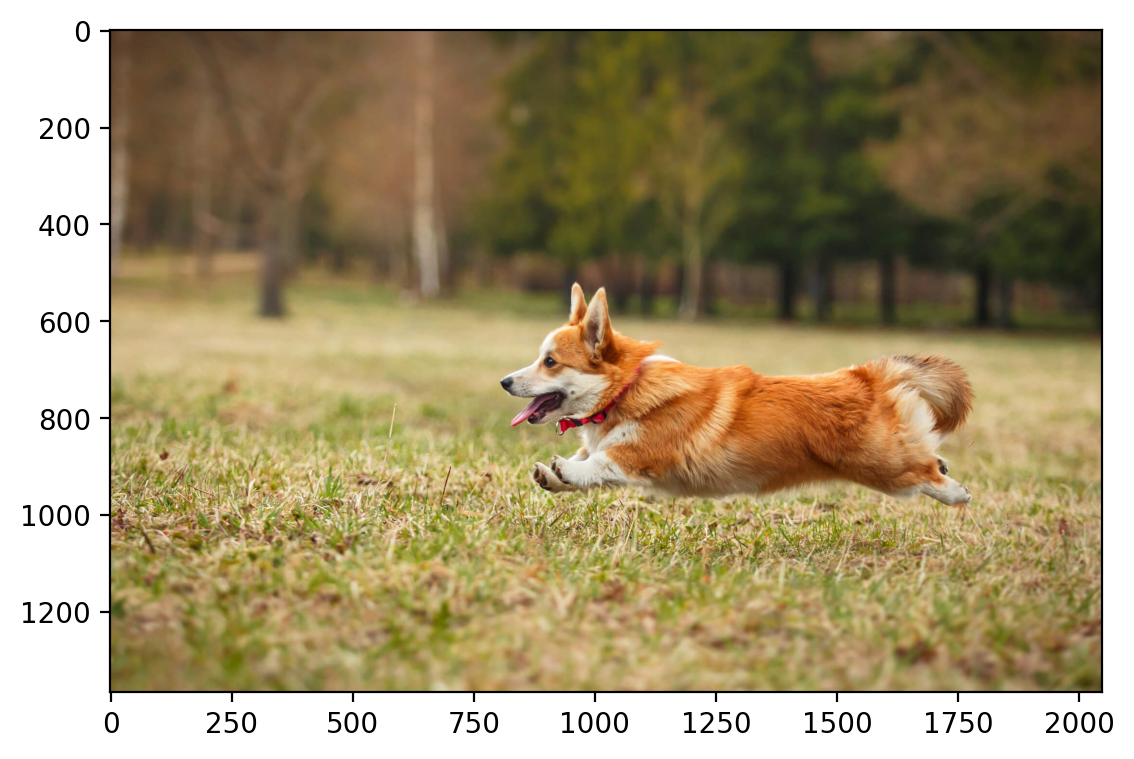

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape
crop.to(device)

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5608, 0.5608, 0.5608],
         [0.7725, 0.7725, 0.7725,  ..., 0.5608, 0.5608, 0.5608],
         [0.7765, 0.7765, 0.7765,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.6196, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6549],
         [0.6157, 0.6706, 0.7216,  ..., 0.6824, 0.7059, 0.7216],
         [0.6353, 0.6902, 0.7294,  ..., 0.7137, 0.7490, 0.7725]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.4706, 0.4706, 0.4706],
         [0.6980, 0.6980, 0.6980,  ..., 0.4706, 0.4706, 0.4706],
         [0.7020, 0.7020, 0.7020,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.5176, 0.5333, 0.5255,  ..., 0.4431, 0.4353, 0.4314],
         [0.5333, 0.5922, 0.6353,  ..., 0.5020, 0.5137, 0.5176],
         [0.5647, 0.6196, 0.6549,  ..., 0.5529, 0.5686, 0.5843]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3373, 0.3373, 0.3373],
         [0.4784, 0.4784, 0.4784,  ..., 0.3373, 0.3373, 0.3373],
         [0.4824, 0.4824, 0.4824,  ..., 0.3412, 0.3412, 0.

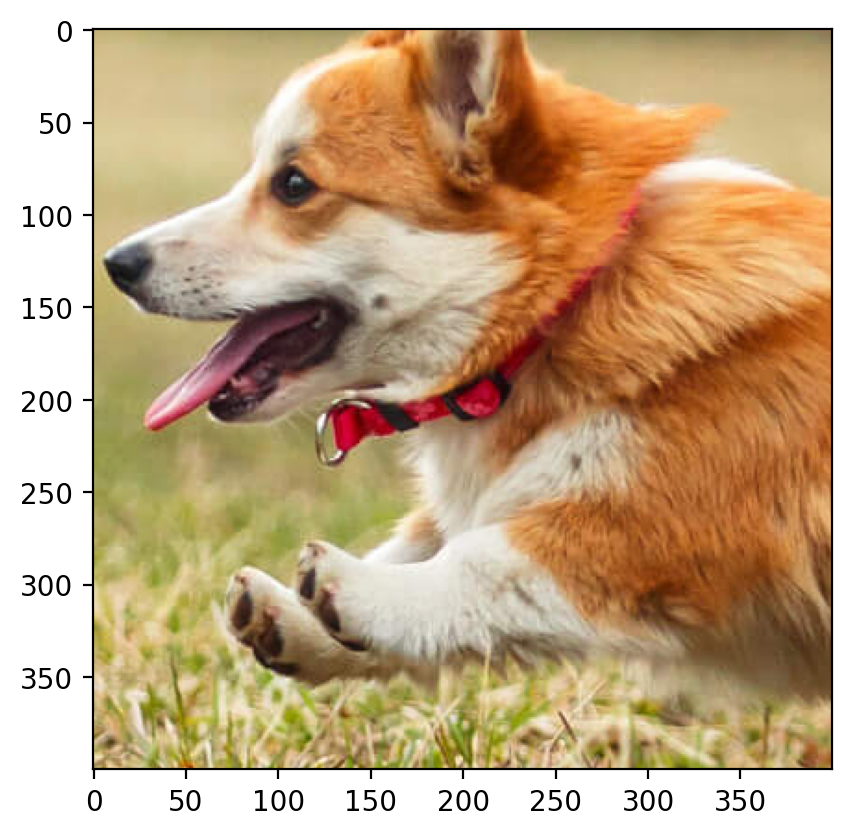

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [10]:
crop_ = rearrange(crop, 'c h w -> (h w) c').float()
crop_.to(device)

tensor([[0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        [0.7686, 0.6941, 0.4745],
        ...,
        [0.7137, 0.5529, 0.3098],
        [0.7490, 0.5686, 0.3647],
        [0.7725, 0.5843, 0.4039]], device='cuda:0')

In [11]:
import torch.nn.functional as F
resized_img_tensor = F.interpolate(crop.unsqueeze(0), size=200, mode='bilinear', align_corners=False)
resized_img_tensor = resized_img_tensor.squeeze(0)


In [12]:
resized_img_tensor.shape

torch.Size([3, 200, 200])

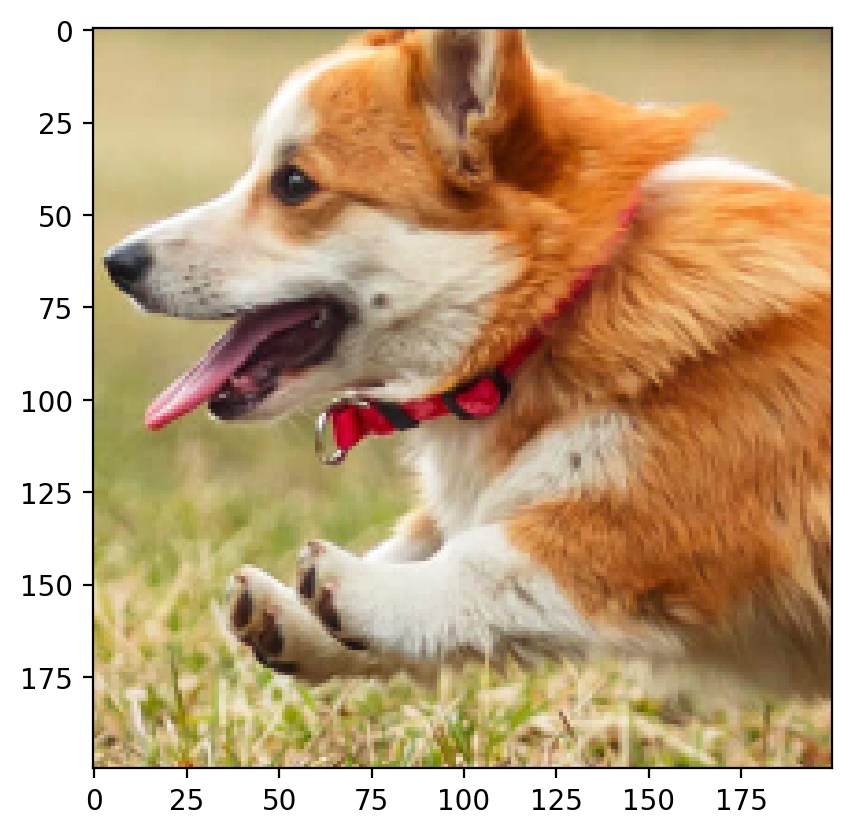

In [13]:
plt.imshow(rearrange(resized_img_tensor, 'c h w -> h w c').cpu().numpy())


In [14]:
resized_ = rearrange(resized_img_tensor, 'c h w -> (h w) c').float()

In [15]:
resized_.shape

torch.Size([40000, 3])

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [17]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [18]:
def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    epochs: int
    batch_size: int, default=32
    verbose: bool, default=True
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(num_batches):
            optimizer.zero_grad()
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_X = X[start_idx:end_idx]
            batch_Y = Y[start_idx:end_idx]
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")


In [19]:
crop_.shape

torch.Size([160000, 3])

In [20]:
w_coords = torch.arange(0,300,0.5).repeat(300, 1)
w_coords


tensor([[  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000],
        [  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000],
        [  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000],
        ...,
        [  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000],
        [  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000],
        [  0.0000,   0.5000,   1.0000,  ..., 298.5000, 299.0000, 299.5000]])

In [21]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0,width,0.5).repeat(2*height, 1)
    h_coords = torch.arange(0,height,0.5).repeat(2*width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [22]:
dog_X,dog_Y=create_coordinate_map(resized_img_tensor)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [23]:
X_rff = create_rff_features(dog_X_scaled, 10000, 0.008)
print(X_rff.shape)
X_rff=X_rff.cpu().numpy()
X_final = np.random.random((40000, 10000))
j=0
for i in range(400):
  if i%2==0:
    X_=X_rff[i*400:i*400+400,:]
    X__=X_[::2,:]
    X_final[j*200:j*200+200,:]=X__
    j=j+1
X_rff=torch.tensor(X_rff,dtype=torch.float32).to(device)
X_final=torch.tensor(X_final,dtype=torch.float32).to(device)
net = LinearModel(X_final.shape[1], 3)
net.to(device)
# resized_.to(device)
resized_=torch.tensor(resized_,dtype=torch.float32).to(device)
train(net, 0.005, X_final,resized_, 1000,100,True)

torch.Size([160000, 10000])
Epoch 0 loss: 0.087482
Epoch 100 loss: 0.011532
Epoch 200 loss: 0.010124
Epoch 300 loss: 0.009800
Epoch 400 loss: 0.009686
Epoch 500 loss: 0.009637
Epoch 600 loss: 0.009619
Epoch 700 loss: 0.009619
Epoch 800 loss: 0.009631
Epoch 900 loss: 0.009650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


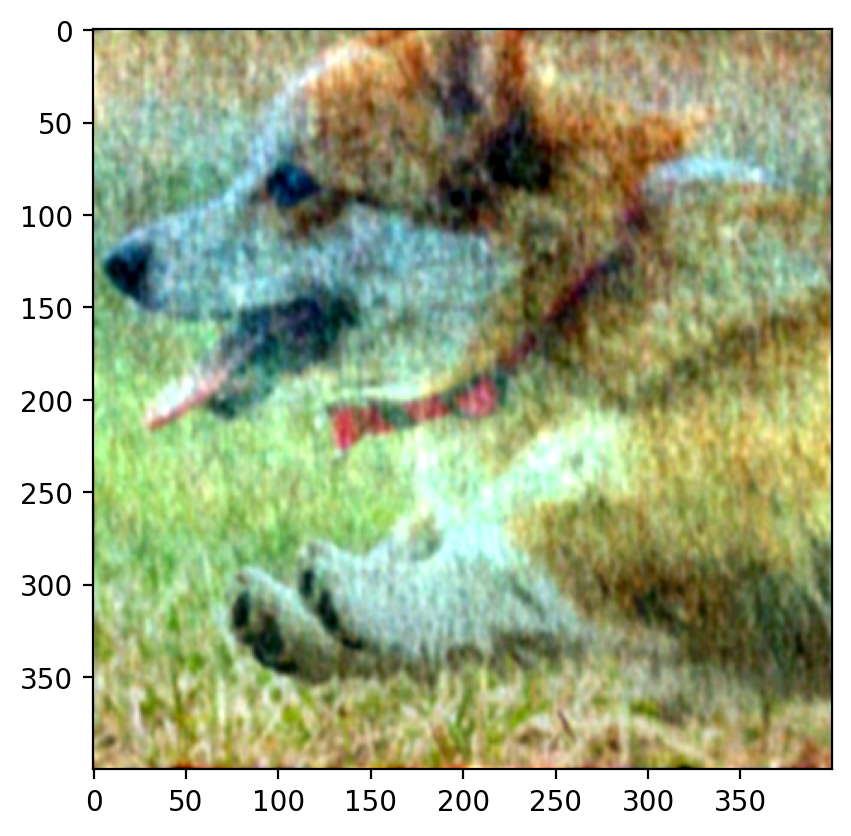

In [24]:
with torch.no_grad():
      outputs = net(X_rff)
      outputs = outputs.reshape(400, 400, 3)
plt.imshow(outputs.cpu())

In [25]:
def plot_reconstructed_and_original_image_RFF(original_img, net, X,maskedImage, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(400, 400, 3)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax2.set_title(f" 400*400")
    ax2.imshow(outputs.cpu())
    ax0.set_title("Original Image")
    ax0.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title(" 200*200")
    #ax1.imshow(maskedImage.reshape(200,200,3).cpu().numpy())
    ax1.imshow(rearrange(maskedImage, 'c h w -> h w c').cpu().numpy())
    squared_error = torch.square(outputs.cpu() - original_img.cpu().permute(1,2,0))
    mse = torch.mean(squared_error)


    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    # Errors_rff["Type"].append(title)
    # Errors_rff["RMSE"].append(rmse.cpu().detach().numpy())
    # Errors_rff["Peak SNR"].append(psnr.cpu().detach().numpy())
    print(f"Type: {title} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Type: Reconstructed Image , RMSE: 0.1698637812861144, PSNR: 7.698992124459096 



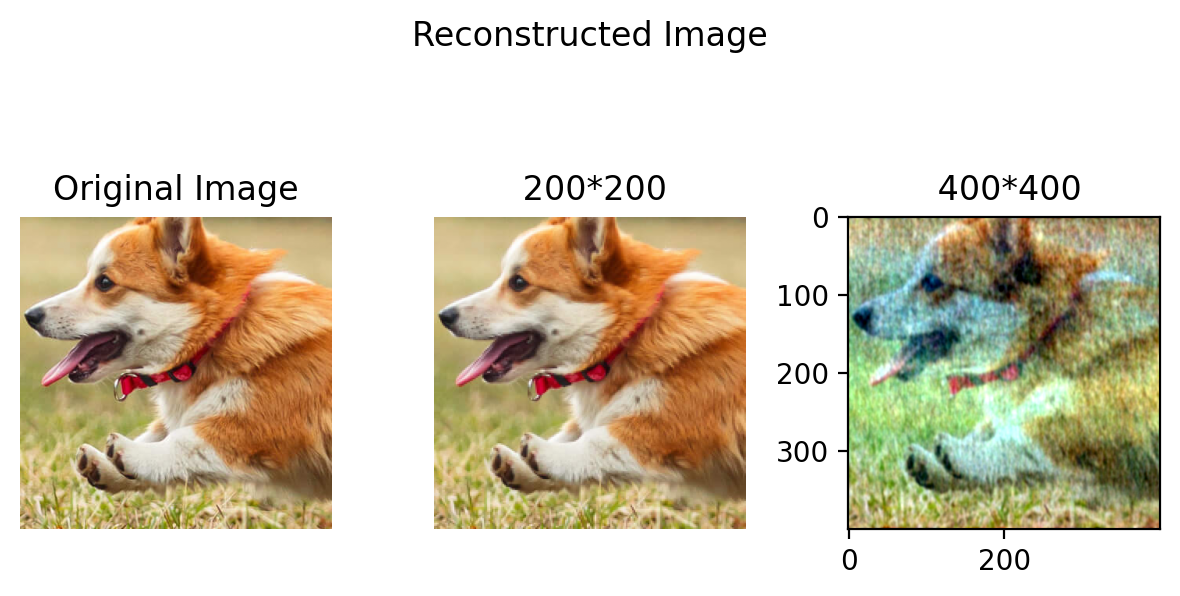

In [26]:
plot_reconstructed_and_original_image_RFF(crop, net, X_rff,resized_img_tensor, title=f"Reconstructed Image")